In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models import MobileNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB
from tqdm import tqdm

# Setting

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [4]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [5]:
device = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [9]:
num_class = 43

In [10]:
len(train_dataset)

26640

11


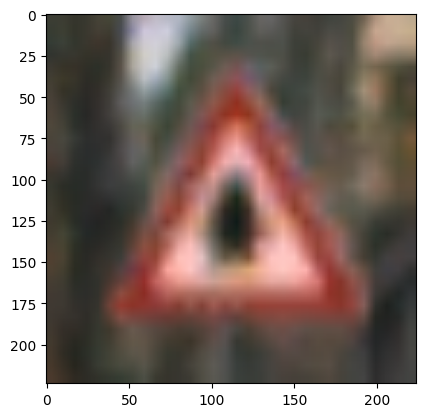

In [11]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [12]:
model = MobileNetV2(output_size=num_class).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MobileNetV2                                                       --
├─Sequential: 1-1                                                 --
│    └─ConvBnRelu: 2-1                                            --
│    │    └─Conv2d: 3-1                                           864
│    │    └─BatchNorm2d: 3-2                                      64
│    │    └─ReLU: 3-3                                             --
│    └─InvertedResidualBlock: 2-2                                 --
│    │    └─ResBlock: 3-4                                         2,528
│    └─InvertedResidualBlock: 2-3                                 --
│    │    └─LinearBottleneck: 3-5                                 5,136
│    └─InvertedResidualBlock: 2-4                                 --
│    │    └─ResBlock: 3-6                                         8,832
│    └─InvertedResidualBlock: 2-5                                 --
│    │    └─LinearB

# training

In [14]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [15]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [16]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(train_dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 416/416 [01:20<00:00,  5.15it/s]


epoch 1: 0.00893878677115963


100%|██████████| 416/416 [01:21<00:00,  5.10it/s]


epoch 2: 0.0026156708083532234


100%|██████████| 416/416 [01:41<00:00,  4.09it/s]


epoch 3: 0.0006865725201602141


100%|██████████| 416/416 [01:19<00:00,  5.21it/s]


epoch 4: 0.0003603340380992209


100%|██████████| 416/416 [01:18<00:00,  5.33it/s]


epoch 5: 0.0002281547811970621


100%|██████████| 416/416 [01:19<00:00,  5.24it/s]


epoch 6: 0.0001500802801167886


100%|██████████| 416/416 [01:19<00:00,  5.24it/s]


epoch 7: 0.00012384768970123304


100%|██████████| 416/416 [01:25<00:00,  4.86it/s]


epoch 8: 0.00011084260426855167


100%|██████████| 416/416 [01:19<00:00,  5.20it/s]


epoch 9: 9.957985038435235e-05


100%|██████████| 416/416 [01:19<00:00,  5.21it/s]

epoch 10: 9.41011562451228e-05


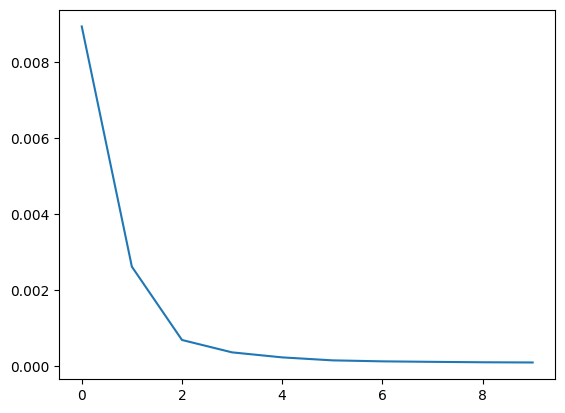

In [30]:
plt.plot(training_loss)

# inference

In [17]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [18]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [19]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [20]:
evaluator = ClassificationEvaluator(num_class, device)

In [21]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 198/198 [00:29<00:00,  6.77it/s]


In [22]:
print(confusion_matrix)

[[ 60   0   0 ...   0   0   0]
 [  7 699   3 ...   0   0   0]
 [  0   1 738 ...   0   0   0]
 ...
 [  0   0   1 ...  86   0   0]
 [  0   0   0 ...   0  49   3]
 [  0   0   0 ...   0   5  85]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9708333333333333
2         : 0.984
3         : 0.9711111111111111
4         : 0.9621212121212122
5         : 0.9507936507936507
6         : 0.8466666666666667
7         : 0.9911111111111112
8         : 0.96
9         : 0.9958333333333333
10        : 1.0
11        : 0.9976190476190476
12        : 0.9405797101449276
13        : 0.9972222222222222
14        : 1.0
15        : 0.9952380952380953
16        : 0.9533333333333334
17        : 0.8972222222222223
18        : 0.9435897435897436
19        : 0.5666666666666667
20        : 0.8111111111111111
21        : 0.6666666666666666
22        : 0.7416666666666667
23        : 0.94
24        : 0.8
25        : 0.94375
26        : 0.9722222222222222
27        : 0.5
28        : 0.9733333333333334
29        : 0.9888888888888889
30        : 0.8333333333333334
31        : 0.9925925925925926
32        : 1.0
33        : 0.7476190476190476
34        : 0.9666666666666667
35        : 0.9615384615384616
36        : 0.941666666666

In [24]:
per_class_acc.mean()

0.8866345807415069

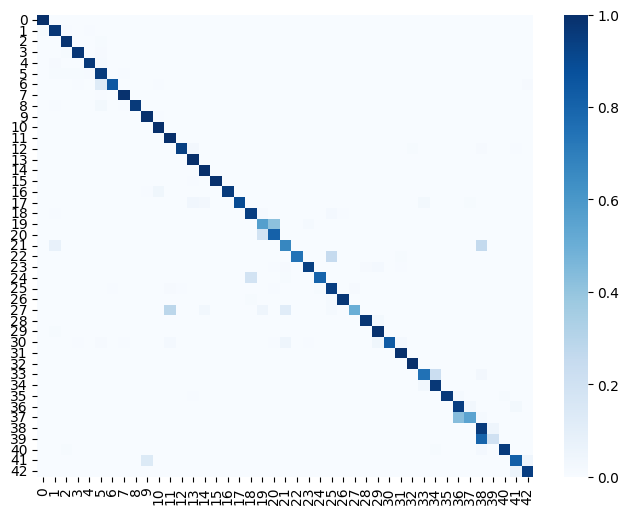

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / 'mobilenetV2.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
model_path.stat().st_size / 1024**2

9.181982040405273

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>